## Setup

In [1]:
import os
import sys
sys.path.append(os.path.abspath('../'))
import torch
import tqdm
import time
from UNet import UNet
from ModelWrapper import ModelWrapper
from cddpm import cddpm
from dataset import dataset
import matplotlib.pyplot as plt 
import json
import torch.nn.functional as F
from FID_class import FID
from torch.optim.lr_scheduler import PolynomialLR

## Checkpoints

save_checkpoints: True = Checkpoints will be saved, False  = Checkpoints will not be saved

load_for_continuation: True = Start from the last checkpoint, False = Start from scratch 

If false, the model will orverride the existing checkpoints

In [2]:
save_checkpoints = True
load_for_continuation = True
print(os.getcwd())
checkpoint_interval = 5 #<-- How often should we do checkpoints
model_save_path = './checkpoints/'
checkpoint_filename = 'model_checkpoint.pth'
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

e:\AI\TDDE70\tdde70_project\structured_code\DDPM


## Parameters and imports 

cuda
Seed: 0
Dataset will be downloaded to: e:\AI\TDDE70\tdde70_project\structured_code\datasets
Files already downloaded and verified
torch.Size([128, 3, 32, 32])


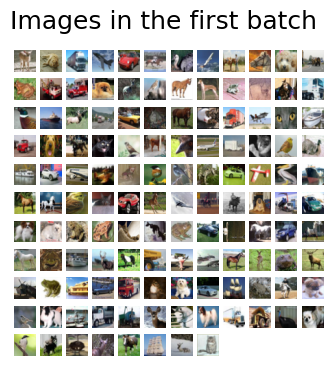

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
num_epochs = 500
img_size = 32 
batch_size = 128
eval_batch_size = 20

# Initialize model
model = UNet().to(device)
cddpm = cddpm()
cifar10 = dataset(batch_size)
dataloader = cifar10.dataloader

# Initialize Optimizer
#The learning rate is double the one in paper since we run half of the numb of epoch so that the decay is not to quick
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = PolynomialLR(optimizer, total_iters=num_epochs, power=2.0) #polynomial decay since power = 2
start_epoch = 0

## Train Loop

In [ ]:
training_time_file = "training_time_ddpm.json"

#Rename the jsonfile that exists if doing a new run
loss_history_file = "loss_history_ddpm.json"

if load_for_continuation and os.path.exists(model_save_path + checkpoint_filename):
    checkpoint = torch.load(model_save_path + checkpoint_filename, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    if os.path.exists(loss_history_file):
        with open(loss_history_file, "r") as file:
            loss_history = json.load(file)
    else:
        loss_history = {}
    print(f"Resuming training from epoch {start_epoch}")

# Check if loss history file exists and is not empty, otherwise initialize it
if not os.path.exists(loss_history_file) or os.stat(loss_history_file).st_size == 0:
    with open(loss_history_file, "w") as file:
        json.dump({}, file)

# Start the timer at the beginning of the training session
start_time = time.time()
print("Training model...")
for epoch in range(start_epoch, num_epochs):
    model.train()
    lbar = tqdm.tqdm(cifar10.dataloader)
    lbar.set_description(f"Epoch {epoch}")
    total_loss = 0
    for i, (images, labels) in enumerate(lbar):
        images, labels = images.to(device), labels.to(device)
        noise = torch.randn_like(images).to(device)
        t = cddpm.sample_timesteps(images.shape[0]).to(device)
        x_t = cddpm.add_noise(images, noise, t)
        predicted_noise = model(t, x_t, labels)
        loss = F.mse_loss(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    scheduler.step()
    average_loss = total_loss / len(lbar)
    current_lr = scheduler.get_last_lr()[0]
    print(f"Avg loss for epoch {epoch}: {average_loss}, Current LR: {current_lr}")

    # Update the JSON file with the new loss for the current epoch
    with open(loss_history_file, "r") as file:
        loss_history = json.load(file)
    loss_history[epoch] = average_loss
    with open(loss_history_file, "w") as file:
        json.dump(loss_history, file, indent=4)

    if save_checkpoints and (epoch % checkpoint_interval == 0 or epoch == num_epochs - 1):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_history,
        }
        torch.save(checkpoint, model_save_path + f"Checkpoint_{epoch}.pth")

# Calculate total training time
end_time = time.time()
training_duration = end_time - start_time

# Convert seconds to hour, minutes, and seconds
hours = int(training_duration // 3600)
minutes = int((training_duration % 3600) // 60)
seconds = int(training_duration % 60)

# Save the total training time to a JSON file
with open(training_time_file, "w") as file:
    json.dump({
        "hours": hours,
        "minutes": minutes,
        "seconds": seconds
    }, file, indent=4)

print(f"Training completed in {hours} hours, {minutes} minutes, and {seconds} seconds.")

## Display images from checkpoint

999it [00:21, 46.52it/s]


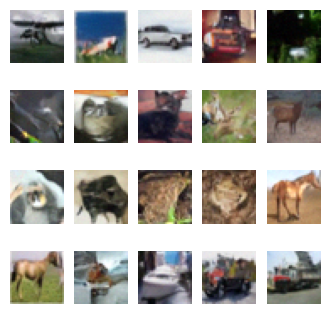

In [4]:
 # NOTE: Change this to the actual checkpoint path
checkpoint_path = "./checkpoints/Checkpoint_499.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Number of images to show:
image_batch_size = 20

model.eval()
labels = torch.tensor([0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9]).to(device)
with torch.no_grad():
    sample = torch.randn((image_batch_size, 3, img_size, img_size)).to(device)
    for i in tqdm.tqdm(reversed(range(1, cddpm.num_timesteps)), position= 0):
        t = (torch.ones(image_batch_size) * i).long().to(device)
        predicted_noise = model(t, sample, labels)
        sample = cddpm.step(predicted_noise, i, sample)
    output = sample.clamp(0,1)
    cifar10.show_images(output)

## Calculate evaluation metrics for checkpoint:

In [19]:
import gc

def load_model_definition():
    model = UNet().to(device)
    model.eval()
    return model.to(device)

def load_fid_scores():
    try:
        with open("fid_ddpm.json", "r") as file:
            return json.load(file)
    except FileNotFoundError:
        return {}  # Return an empty dictionary if the file does not exist

# Initialize device and FID calculator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fid = FID()

# Load existing FID scores
fid_scores = load_fid_scores()

# Loop over checkpoints
for epoch in [50, 100, 150, 200, 250, 300, 350, 400, 450, 499]:
    model = load_model_definition()
    checkpoint_path = f"./checkpoints/Checkpoint_{epoch}.pth"
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Calculate FID
    fid_score = fid.calculate_FID_DDPM(model, cddpm, 1500, 32, device)
    fid_scores[epoch] = fid_score
    print(f"FID for Checkpoint {epoch}: {fid_score}")

    # Write FID scores to JSON
    with open("fid_ddpm.json", "w") as file:
        json.dump(fid_scores, file, indent=4)

    # Clear memory
    del model
    torch.cuda.empty_cache()
    gc.collect()


Files already downloaded and verified
Saving real images...
Real images Saved, beginning Evaluation...


999it [00:20, 49.68it/s]
999it [00:19, 50.62it/s]
999it [00:19, 51.02it/s]
999it [00:19, 51.44it/s]
999it [00:19, 51.13it/s]
999it [00:19, 50.56it/s]
999it [00:19, 52.15it/s]
999it [00:19, 51.87it/s]
999it [00:19, 51.74it/s]
999it [00:19, 51.86it/s]
999it [00:19, 51.80it/s]
999it [00:19, 51.72it/s]
999it [00:19, 51.73it/s]
999it [00:19, 51.67it/s]
999it [00:19, 51.81it/s]
999it [00:19, 51.78it/s]
999it [00:19, 51.59it/s]
999it [00:19, 51.93it/s]
999it [00:19, 51.92it/s]
999it [00:19, 51.53it/s]
999it [00:19, 51.10it/s]
999it [00:19, 50.97it/s]
999it [00:18, 52.58it/s]
999it [00:18, 53.08it/s]
999it [00:18, 53.06it/s]
999it [00:18, 53.13it/s]
999it [00:18, 53.08it/s]
999it [00:18, 53.12it/s]
999it [00:19, 51.34it/s]
999it [00:19, 50.46it/s]
999it [00:19, 50.57it/s]
999it [00:19, 50.54it/s]
999it [00:19, 50.48it/s]
999it [00:19, 50.56it/s]
999it [00:19, 50.45it/s]
999it [00:19, 50.45it/s]
999it [00:19, 50.65it/s]
999it [00:19, 50.71it/s]
999it [00:19, 50.77it/s]
999it [00:19, 50.64it/s]


FID for Checkpoint 50: 149.28564553807323
Saving real images...
Real images Saved, beginning Evaluation...


999it [00:19, 50.01it/s]
999it [00:19, 51.04it/s]
999it [00:19, 50.99it/s]
999it [00:19, 50.99it/s]
999it [00:19, 50.95it/s]
999it [00:19, 50.93it/s]
999it [00:19, 50.77it/s]
999it [00:19, 50.76it/s]
999it [00:19, 50.44it/s]
999it [00:19, 51.66it/s]
999it [00:19, 51.62it/s]
999it [00:19, 51.65it/s]
999it [00:19, 51.63it/s]
999it [00:19, 51.66it/s]
999it [00:19, 51.61it/s]
999it [00:19, 51.63it/s]
999it [00:19, 51.62it/s]
999it [00:19, 51.66it/s]
999it [00:19, 51.66it/s]
999it [00:19, 51.67it/s]
999it [00:19, 51.64it/s]
999it [00:19, 51.54it/s]
999it [00:19, 51.69it/s]
999it [00:19, 51.59it/s]
999it [00:19, 51.59it/s]
999it [00:19, 51.59it/s]
999it [00:19, 51.61it/s]
999it [00:19, 51.60it/s]
999it [00:19, 51.58it/s]
999it [00:19, 51.57it/s]
999it [00:19, 51.61it/s]
999it [00:19, 51.58it/s]
999it [00:19, 51.59it/s]
999it [00:19, 51.64it/s]
999it [00:19, 51.65it/s]
999it [00:19, 51.63it/s]
999it [00:19, 51.58it/s]
999it [00:19, 51.70it/s]
999it [00:19, 51.64it/s]
999it [00:19, 51.60it/s]


FID for Checkpoint 100: 158.6229249910253
Saving real images...
Real images Saved, beginning Evaluation...


999it [00:19, 50.37it/s]
999it [00:19, 50.54it/s]
999it [00:19, 50.47it/s]
999it [00:19, 50.59it/s]
999it [00:19, 50.59it/s]
999it [00:19, 50.50it/s]
999it [00:19, 50.56it/s]
999it [00:19, 50.66it/s]
999it [00:19, 50.85it/s]
999it [00:19, 50.87it/s]
999it [00:19, 50.65it/s]
999it [00:19, 50.56it/s]
999it [00:19, 50.57it/s]
999it [00:19, 50.63it/s]
999it [00:19, 50.64it/s]
999it [00:19, 50.57it/s]
999it [00:19, 50.67it/s]
999it [00:19, 50.63it/s]
999it [00:19, 50.60it/s]
999it [00:19, 50.68it/s]
999it [00:19, 50.61it/s]
999it [00:19, 50.81it/s]
999it [00:19, 50.79it/s]
999it [00:19, 50.73it/s]
999it [00:19, 50.62it/s]
999it [00:19, 50.62it/s]
999it [00:19, 50.55it/s]
999it [00:19, 50.62it/s]
999it [00:19, 50.64it/s]
999it [00:19, 50.67it/s]
999it [00:19, 50.60it/s]
999it [00:19, 50.55it/s]
999it [00:19, 50.60it/s]
999it [00:19, 50.56it/s]
999it [00:19, 50.75it/s]
999it [00:19, 50.86it/s]
999it [00:19, 50.85it/s]
999it [00:19, 50.63it/s]
999it [00:19, 50.56it/s]
999it [00:19, 50.63it/s]


FID for Checkpoint 150: 169.64501967607367
Saving real images...
Real images Saved, beginning Evaluation...


999it [00:19, 51.49it/s]
999it [00:19, 52.25it/s]
999it [00:19, 52.39it/s]
999it [00:19, 52.11it/s]
999it [00:19, 52.26it/s]
999it [00:19, 52.13it/s]
999it [00:19, 52.26it/s]
999it [00:19, 52.23it/s]
999it [00:19, 52.25it/s]
999it [00:19, 52.17it/s]
999it [00:19, 52.20it/s]
999it [00:19, 52.24it/s]
999it [00:19, 52.16it/s]
999it [00:19, 52.27it/s]
999it [00:19, 52.23it/s]
999it [00:19, 52.29it/s]
999it [00:19, 52.25it/s]
999it [00:19, 52.26it/s]
999it [00:19, 52.26it/s]
999it [00:19, 52.28it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.26it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.31it/s]
999it [00:19, 52.13it/s]
999it [00:19, 52.30it/s]
999it [00:19, 52.33it/s]
999it [00:19, 52.24it/s]
999it [00:19, 52.32it/s]
999it [00:19, 52.28it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.27it/s]
999it [00:19, 52.12it/s]
999it [00:19, 52.20it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.10it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.27it/s]
999it [00:19, 52.26it/s]


FID for Checkpoint 200: 181.11417884848908
Saving real images...
Real images Saved, beginning Evaluation...


999it [00:19, 51.44it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.19it/s]
999it [00:19, 52.09it/s]
999it [00:19, 52.12it/s]
999it [00:19, 52.15it/s]
999it [00:19, 52.09it/s]
999it [00:19, 52.10it/s]
999it [00:19, 52.13it/s]
999it [00:19, 52.08it/s]
999it [00:19, 52.08it/s]
999it [00:19, 52.08it/s]
999it [00:19, 52.11it/s]
999it [00:19, 52.08it/s]
999it [00:19, 52.16it/s]
999it [00:19, 52.19it/s]
999it [00:19, 52.15it/s]
999it [00:19, 52.03it/s]
999it [00:19, 52.09it/s]
999it [00:19, 51.95it/s]
999it [00:19, 51.96it/s]
999it [00:19, 52.09it/s]
999it [00:19, 51.98it/s]
999it [00:19, 51.91it/s]
999it [00:19, 51.99it/s]
999it [00:19, 52.11it/s]
999it [00:19, 52.05it/s]
999it [00:19, 51.83it/s]
999it [00:19, 52.08it/s]
999it [00:19, 51.99it/s]
999it [00:19, 52.05it/s]
999it [00:19, 52.09it/s]
999it [00:19, 52.13it/s]
999it [00:19, 52.03it/s]
999it [00:19, 52.11it/s]
999it [00:19, 52.05it/s]
999it [00:19, 52.05it/s]
999it [00:19, 52.10it/s]
999it [00:19, 52.10it/s]
999it [00:19, 52.09it/s]


FID for Checkpoint 250: 156.1198840349475
Saving real images...
Real images Saved, beginning Evaluation...


999it [00:19, 51.32it/s]
999it [00:19, 52.19it/s]
999it [00:19, 52.36it/s]
999it [00:19, 52.29it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.27it/s]
999it [00:19, 52.19it/s]
999it [00:19, 52.25it/s]
999it [00:19, 52.23it/s]
999it [00:19, 52.31it/s]
999it [00:19, 52.19it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.22it/s]
999it [00:19, 52.28it/s]
999it [00:19, 52.22it/s]
999it [00:19, 52.25it/s]
999it [00:19, 52.20it/s]
999it [00:19, 52.19it/s]
999it [00:19, 52.26it/s]
999it [00:19, 52.23it/s]
999it [00:19, 52.24it/s]
999it [00:19, 52.23it/s]
999it [00:19, 52.24it/s]
999it [00:19, 52.17it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.25it/s]
999it [00:19, 52.20it/s]
999it [00:19, 52.22it/s]
999it [00:19, 52.27it/s]
999it [00:19, 52.10it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.30it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.23it/s]
999it [00:19, 52.23it/s]
999it [00:19, 52.27it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.12it/s]
999it [00:19, 52.29it/s]
999it [00:19, 52.19it/s]


FID for Checkpoint 300: 177.76670968249158
Saving real images...
Real images Saved, beginning Evaluation...


999it [00:19, 51.66it/s]
999it [00:19, 52.28it/s]
999it [00:19, 52.25it/s]
999it [00:19, 52.20it/s]
999it [00:19, 52.15it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.12it/s]
999it [00:19, 52.14it/s]
999it [00:19, 52.16it/s]
999it [00:19, 52.17it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.15it/s]
999it [00:19, 52.12it/s]
999it [00:19, 52.10it/s]
999it [00:19, 52.01it/s]
999it [00:19, 52.25it/s]
999it [00:19, 52.17it/s]
999it [00:19, 52.14it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.10it/s]
999it [00:19, 52.19it/s]
999it [00:19, 52.14it/s]
999it [00:19, 52.14it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.19it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.06it/s]
999it [00:19, 52.08it/s]
999it [00:19, 52.11it/s]
999it [00:19, 52.04it/s]
999it [00:19, 52.12it/s]
999it [00:19, 52.11it/s]
999it [00:19, 52.11it/s]
999it [00:19, 52.12it/s]
999it [00:19, 52.07it/s]
999it [00:19, 52.02it/s]
999it [00:19, 52.12it/s]
999it [00:19, 52.09it/s]
999it [00:19, 51.99it/s]
999it [00:19, 52.10it/s]


FID for Checkpoint 350: 147.72828637817838
Saving real images...
Real images Saved, beginning Evaluation...


999it [00:19, 51.61it/s]
999it [00:19, 52.26it/s]
999it [00:19, 52.27it/s]
999it [00:19, 52.25it/s]
999it [00:19, 52.10it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.20it/s]
999it [00:19, 52.30it/s]
999it [00:19, 52.27it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.28it/s]
999it [00:19, 52.29it/s]
999it [00:19, 52.23it/s]
999it [00:19, 52.27it/s]
999it [00:19, 52.25it/s]
999it [00:19, 52.22it/s]
999it [00:19, 52.29it/s]
999it [00:19, 52.23it/s]
999it [00:19, 52.32it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.27it/s]
999it [00:19, 52.34it/s]
999it [00:19, 52.26it/s]
999it [00:19, 52.33it/s]
999it [00:19, 52.24it/s]
999it [00:19, 52.27it/s]
999it [00:19, 52.28it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.29it/s]
999it [00:19, 52.23it/s]
999it [00:19, 52.28it/s]
999it [00:19, 52.22it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.16it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.13it/s]
999it [00:19, 52.20it/s]
999it [00:19, 52.13it/s]


FID for Checkpoint 400: 150.8723016619047
Saving real images...
Real images Saved, beginning Evaluation...


999it [00:19, 51.50it/s]
999it [00:19, 52.10it/s]
999it [00:19, 52.12it/s]
999it [00:19, 52.16it/s]
999it [00:19, 52.14it/s]
999it [00:19, 52.12it/s]
999it [00:19, 52.09it/s]
999it [00:19, 52.03it/s]
999it [00:19, 52.02it/s]
999it [00:19, 52.04it/s]
999it [00:19, 52.08it/s]
999it [00:19, 52.01it/s]
999it [00:19, 52.00it/s]
999it [00:19, 52.08it/s]
999it [00:19, 52.10it/s]
999it [00:19, 52.06it/s]
999it [00:19, 52.19it/s]
999it [00:19, 52.10it/s]
999it [00:19, 52.19it/s]
999it [00:19, 52.01it/s]
999it [00:19, 52.14it/s]
999it [00:19, 52.17it/s]
999it [00:19, 52.12it/s]
999it [00:19, 52.10it/s]
999it [00:19, 52.08it/s]
999it [00:19, 52.08it/s]
999it [00:19, 52.15it/s]
999it [00:19, 52.08it/s]
999it [00:19, 52.14it/s]
999it [00:19, 52.13it/s]
999it [00:19, 52.11it/s]
999it [00:19, 52.05it/s]
999it [00:19, 52.15it/s]
999it [00:19, 52.09it/s]
999it [00:19, 52.20it/s]
999it [00:19, 52.13it/s]
999it [00:19, 52.12it/s]
999it [00:19, 52.11it/s]
999it [00:19, 52.09it/s]
999it [00:19, 52.04it/s]


FID for Checkpoint 450: 153.2236200563313
Saving real images...
Real images Saved, beginning Evaluation...


999it [00:19, 51.66it/s]
999it [00:19, 52.29it/s]
999it [00:19, 52.15it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.23it/s]
999it [00:19, 52.19it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.11it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.13it/s]
999it [00:19, 52.24it/s]
999it [00:19, 52.20it/s]
999it [00:19, 52.24it/s]
999it [00:19, 52.17it/s]
999it [00:19, 52.14it/s]
999it [00:19, 52.27it/s]
999it [00:19, 52.15it/s]
999it [00:19, 52.22it/s]
999it [00:19, 52.26it/s]
999it [00:19, 52.16it/s]
999it [00:19, 52.17it/s]
999it [00:19, 52.20it/s]
999it [00:19, 52.20it/s]
999it [00:19, 52.24it/s]
999it [00:19, 52.21it/s]
999it [00:19, 52.15it/s]
999it [00:19, 52.16it/s]
999it [00:19, 52.18it/s]
999it [00:19, 52.13it/s]
999it [00:19, 52.11it/s]
999it [00:19, 52.11it/s]
999it [00:19, 52.22it/s]
999it [00:19, 52.14it/s]
999it [00:19, 52.19it/s]
999it [00:19, 52.23it/s]
999it [00:19, 52.11it/s]
999it [00:19, 52.28it/s]
999it [00:19, 52.17it/s]
999it [00:19, 51.23it/s]


FID for Checkpoint 499: 154.81426477528538


False
./checkpoints/model_checkpoint.pth


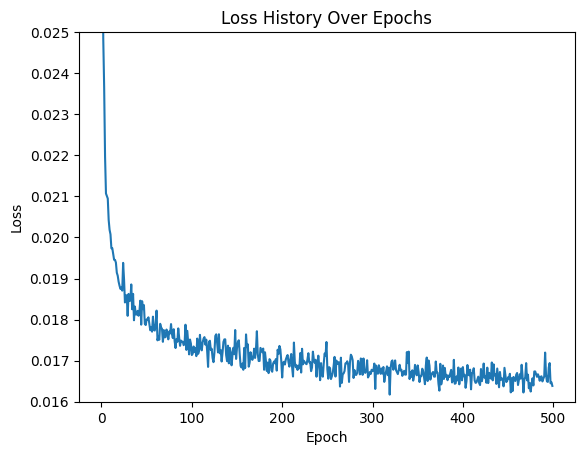

In [10]:
import json
import matplotlib.pyplot as plt

# Assuming model_save_path and checkpoint_filename are defined somewhere above
print(load_for_continuation and os.path.exists(model_save_path + checkpoint_filename))
print(model_save_path + checkpoint_filename)

# Load loss history from JSON file
with open('loss_history_ddpm.json', 'r') as file:
    loss_history = json.load(file)

# We'll use all epochs for plotting
epochs = sorted(int(epoch) for epoch in loss_history.keys())
loss_values = [loss_history[str(epoch)] for epoch in epochs]  # Convert epoch back to string to access dictionary

# Plotting the loss history
plt.plot(epochs, loss_values)
plt.title("Loss History Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Set the Y-axis limits
y_min, y_max = 0.016, 0.025  # Adjust these values based on desired Y-axis range
plt.ylim(y_min, y_max)


plt.savefig('loss_history_ddpm.png', dpi=300)  # dpi specifies the resolution. Higher dpi means better quality.

plt.show()

plt.close()  
